In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

## 3 Visualize Regularization Contours

x.shape: (2, 100), "y.shape:" (1, 100)


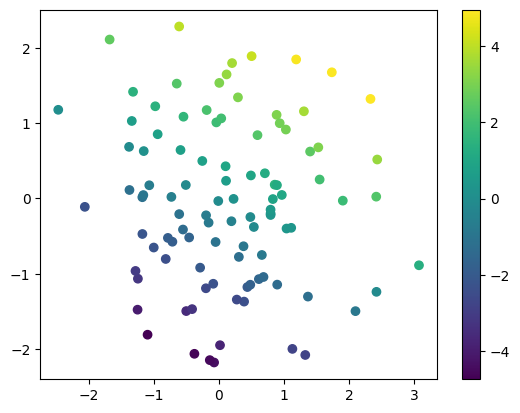

In [2]:
# load the data
data = np.load('data/linreg.npz')
x = data['X']
y = data['Y']
print(f'x.shape: {x.shape}, "y.shape:" {y.shape}')
plt.scatter(*x, c=y);
plt.colorbar()
plt.show()

In [24]:
# create a grid of points in the parameter space
b1, b2 = np.linspace(-1, 3, 100), np.linspace(-1, 3, 100)
bs = np.stack(np.meshgrid(b1, b2, indexing='ij'), axis=-1)
bs.shape

(100, 100, 2)

### (a)

(100, 100)


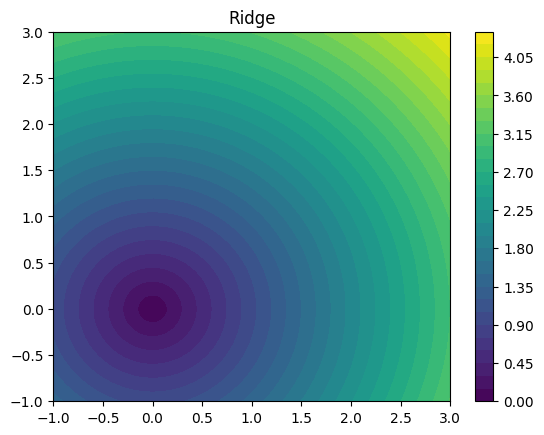

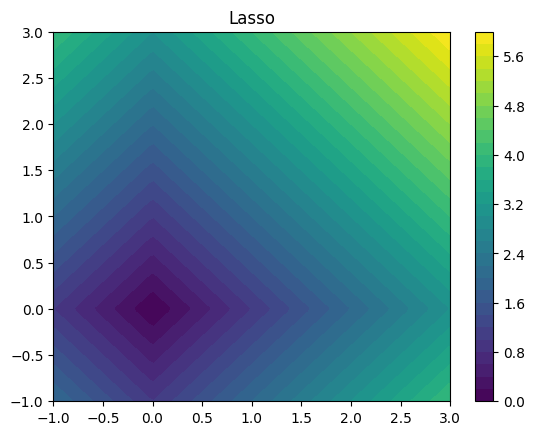

In [ ]:
# Plt the Ridge regression regularisation term as well as Lasso regularisation term
# Ridge
ridge = np.linalg.norm(bs, axis=-1)
plt.contourf(b1, b2,ridge, levels=30)
plt.colorbar()
plt.title('Ridge')
plt.show()

# Lasso
lasso = np.sum(np.abs(bs), axis=-1)
plt.contourf(b1, b2, lasso, levels=30)
plt.colorbar()
plt.title('Lasso')
plt.show()


### (b)

In [32]:
y.shape

(1, 100)

(100, 100)


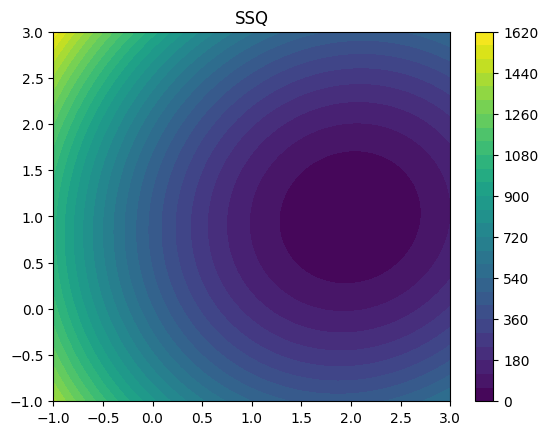

In [36]:
#For the data set linreg.npz plot the sum of squares (SSQ) of a linear regression as a function of β
#over the same range as in i), i.e. over the grid [−1, 3] × [−1, 3].

# use bs grid from above
ssq = np.sum((y[:, None] - bs @ x)**2, axis=2)
print(ssq.shape)
plt.contourf(b1, b2, ssq, levels=30)
plt.colorbar()
plt.title('SSQ')
plt.show()



### (c)

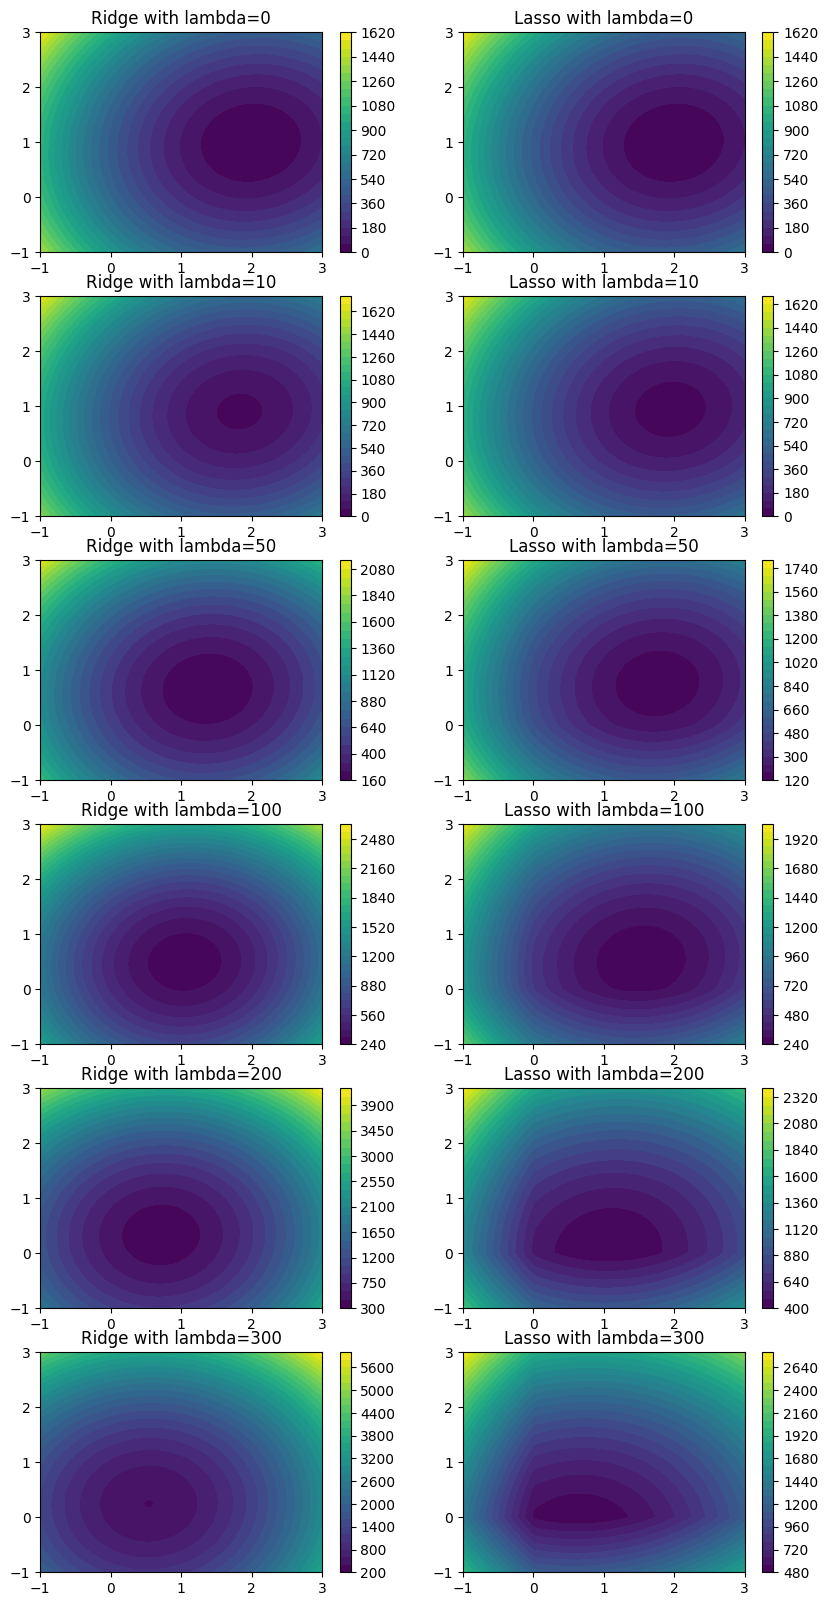

In [44]:
# TODO: for each lambda, plot both ridge regression and lasso loss functions
lambdas = [0, 10, 50, 100, 200, 300]

fig, ax = plt.subplots(6, 2, figsize=(10, 20))
for i in range(len(lambdas)):
    l = lambdas[i]
    ridge = np.linalg.norm(bs, axis=-1)**2
    lasso = np.sum(np.abs(bs), axis=-1)
    ssq = np.sum((y[:, None] - bs @ x)**2, axis=2)
    im = ax[i,0].contourf(b1, b2, ssq + l*ridge, levels=30)
    plt.colorbar(im, ax=ax[i, 0])
    ax[i,0].set_title(f'Ridge with lambda={l}')
    
    im = ax[i,1].contourf(b1, b2, ssq + l*lasso, levels=30)
    plt.colorbar(im, ax=ax[i, 1])
    ax[i,1].set_title(f'Lasso with lambda={l}')

plt.show()

As $\lambda$ increases the centre of the contours shifts towards the origin
For the ridge regression, the contour shape stays the same. Whereas for the Lasso, the countours deform about the axes.

## 4 CT Reconstruction

First, set up the design matrix. (Run this once to save it to the disk)

In [45]:
# create design matrix
# don't change any of this, just run it once to create and save the design matrix
import os

n_parallel_rays = 70 
n_ray_angles = 30
res = (99, 117)
print("Number of pixels in the 2d image:", np.prod(res))
print("Total number of rays:", n_parallel_rays * n_ray_angles)

def rot_mat(angle):
    c, s = np.cos(angle), np.sin(angle)
    return np.stack([np.stack([c, s], axis=-1), np.stack([-s, c], axis=-1)], axis=-1)

kernel = lambda x: np.exp(-x**2/sigma**2/2)

if not os.path.exists('data/design_matrix.npy'):
    xs = np.arange(0, res[1]+1) - res[1]/2 # np.linspace(-1, 1, res[1] + 1)
    ys = np.arange(0, res[0]+1) - res[0]/2 # np.linspace(-1, 1, res[0] + 1)

    # rays are defined by origin and direction
    ray_offset_range = [-res[1]/1.5, res[1]/1.5]
    n_rays = n_parallel_rays * n_ray_angles

    ray_angles = np.linspace(0, np.pi, n_ray_angles, endpoint=False) + np.pi/n_ray_angles

    # offsets for ray_angle = 0, i.e. parallel to x-axis
    ray_0_offsets = np.stack([np.zeros(n_parallel_rays), np.linspace(*ray_offset_range, n_parallel_rays)], axis=-1)
    ray_0_directions = np.stack([np.ones(n_parallel_rays), np.zeros(n_parallel_rays)], axis=-1)

    

    ray_rot_mats = rot_mat(ray_angles)

    ray_offsets = np.einsum('oi,aij->aoj', ray_0_offsets, ray_rot_mats).reshape(-1, 2)
    ray_directions = np.einsum('oi,aij->aoj', ray_0_directions, ray_rot_mats).reshape(-1, 2)

    sigma = 1
    xsc = (xs[1:] + xs[:-1]) / 2
    ysc = (ys[1:] + ys[:-1]) / 2
    b = np.stack(np.meshgrid(xsc, ysc), axis=-1).reshape(-1, 2)
    a = ray_offsets
    v = ray_directions
    v = v / np.linalg.norm(v, axis=-1, keepdims=True)
    p = ((b[None] - a[:, None]) * v[:, None]).sum(-1, keepdims=True) * v[:, None] + a[:, None]
    d = np.linalg.norm(b - p, axis=-1)
    d = kernel(d)
    design_matrix = d.T

    np.save('data/design_matrix.npy', design_matrix)
    print(f'created and saved design matrix of shape {design_matrix.shape} at data/design_matrix.npy')

Number of pixels in the 2d image: 11583
Total number of rays: 2100
created and saved design matrix of shape (11583, 2100) at data/design_matrix.npy


sino shape: (1, 2100)


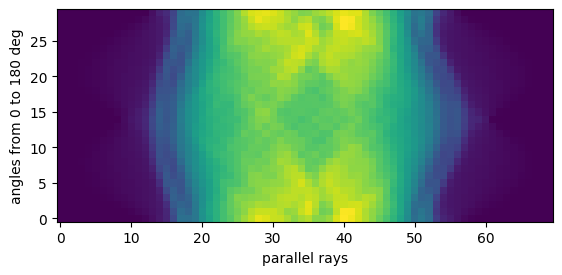

In [70]:
sino = np.load('data/sino.npy')

print(f'sino shape: {sino.shape}')

# visualize sinogram as image
n_parallel_rays = 70
n_angles = 30
plt.imshow(sino.reshape(n_angles, n_parallel_rays), origin='lower')
# plt.colorbar()
plt.xlabel('parallel rays')
plt.ylabel('angles from 0 to 180 deg')
plt.show();

### (a)

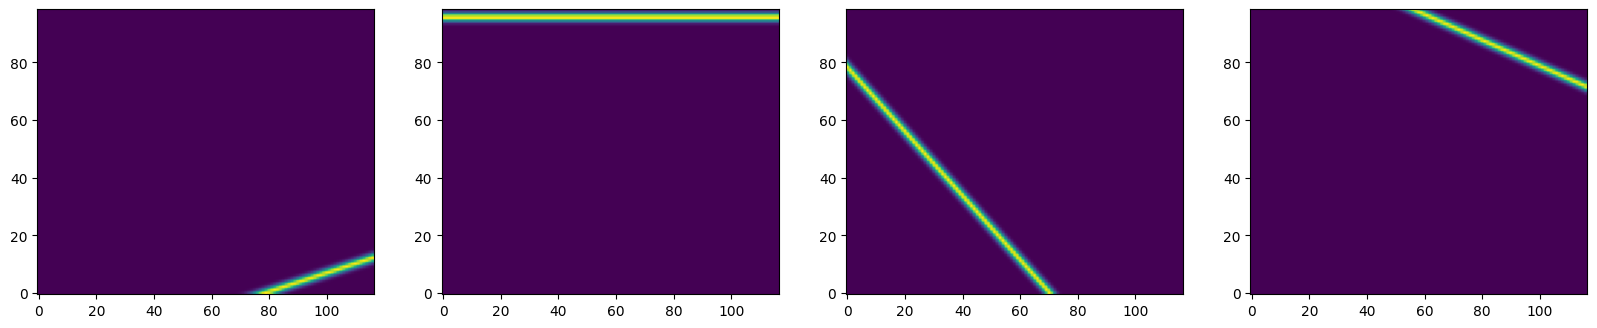

In [61]:
design_matrix = np.load('data/design_matrix.npy')

# TODO: visualize four random columns as images, using an image shape of (99, 117)
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    ax[i].imshow(design_matrix[:, np.random.randint(design_matrix.shape[1])].reshape(99, 117), origin='lower')
plt.show()

The columns show which pixels can be detected by a given ray in the detector

### (b)

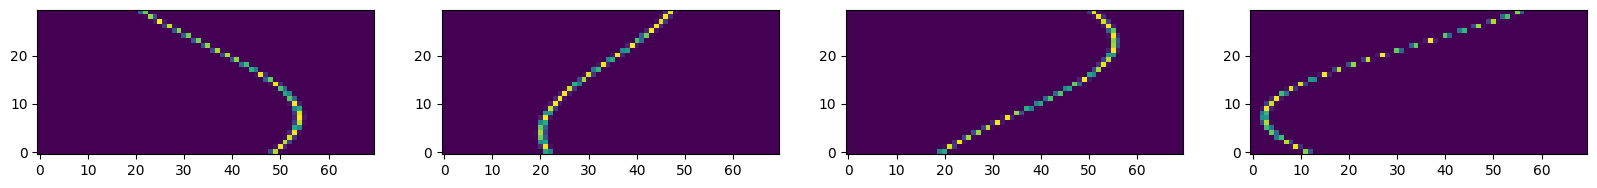

In [62]:
# TODO: visualize four random rows as images, using an images
fig, ax = plt.subplots(1, 4, figsize=(20, 10))
for i in range(4):
    ax[i].imshow(design_matrix[np.random.randint(design_matrix.shape[0])].reshape(30, 70), origin='lower')
plt.show()

The rows show which detectors will be able to detect a given pixel.

### (c)

In [72]:
sino.shape, design_matrix.shape

((1, 2100), (11583, 2100))

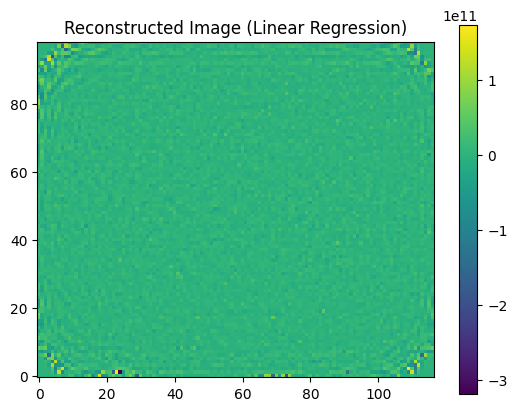

In [77]:
# TODO: solve the reconstruction with linear regression (no regularisation) and visualize the result
# Load the design matrix and sinogram
#design_matrix = np.load('data/design_matrix.npy')
#sino = sino.reshape(n_angles * n_parallel_rays)

# Perform linear regression
model = LinearRegression()
model.fit(design_matrix.T, sino.flatten())
reconstructed_image = model.coef_.reshape(res)

# Visualize the reconstructed image
plt.imshow(reconstructed_image, origin='lower')
plt.title('Reconstructed Image (Linear Regression)')
plt.colorbar()
plt.show()




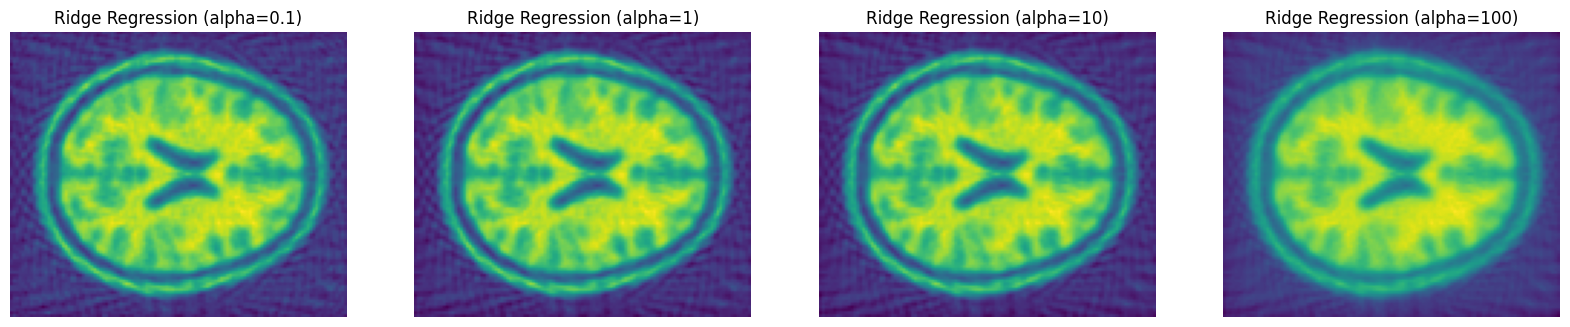

In [79]:
# TODO: solve the reconstruction with ridge regression and visualize the result
# Optional: try out different regularization strengths and oberve the influence
from sklearn.linear_model import Ridge

# Perform ridge regression with different regularization strengths
alphas = [0.1, 1, 10, 100]
fig, ax = plt.subplots(1, len(alphas), figsize=(20, 5))

for i, alpha in enumerate(alphas):
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(design_matrix.T, sino.flatten())
    reconstructed_image_ridge = ridge_model.coef_.reshape(res)
    
    ax[i].imshow(reconstructed_image_ridge, origin='lower')
    ax[i].set_title(f'Ridge Regression (alpha={alpha})')
    ax[i].axis('off')

plt.show()

The Ridge regression considerably outperforms the Linear Regression, which is unable to reconstruct the image in any useful way.

## 5 Bonus: X-Ray Free-Electron Lasers

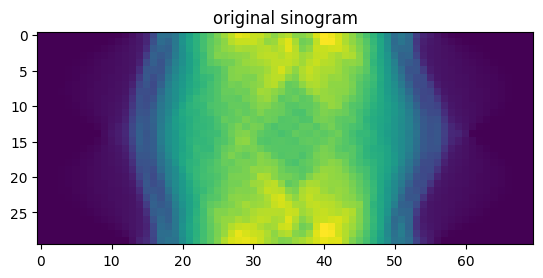

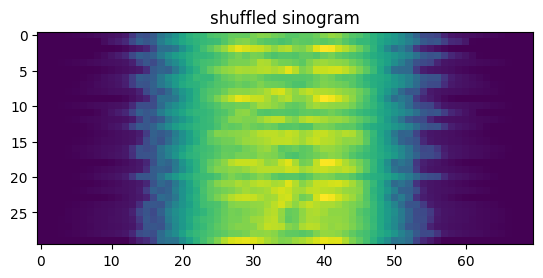

In [118]:
sino = np.load('data/sino.npy').reshape(n_angles, n_parallel_rays)
plt.imshow(sino)
plt.title('original sinogram')
plt.show()

order = np.arange(n_angles)
np.random.shuffle(order)
sino_shuffled = sino[order]
plt.imshow(sino_shuffled)
plt.title('shuffled sinogram')
plt.show()

(30, 70)
(30, 70)
(30, 70)
(30, 70)
(30, 70)
(30, 70)
(30, 70)


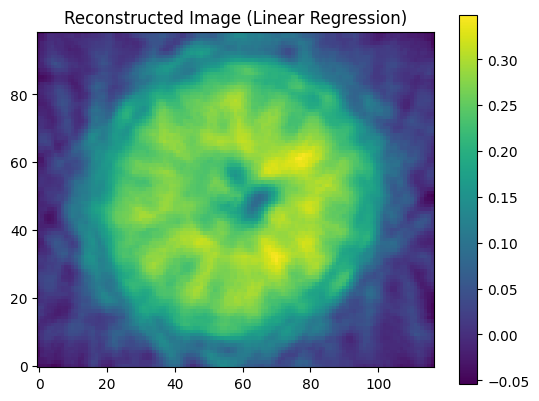

In [ ]:
#Try to reconstruct the image from the data of task 4, after shuffling the sinogram along the angle axis
#Perturbatively perform Ridge regression

alphas = [100, 50, 20, 10, 1, 0.1]
sino_pert = sino_shuffled
print(sino_pert.shape)
for i, alpha in enumerate(alphas):
    model = Ridge(alpha=alpha)
    model.fit(design_matrix.T, sino_pert.flatten())
    reconstructed_image = model.coef_.reshape(res)
    sino_pert = (model.coef_[:,np.newaxis].T @ design_matrix).reshape(30,70)
    print(sino_pert.shape)

# Visualize the reconstructed image
plt.imshow(reconstructed_image, origin='lower')
plt.title('Reconstructed Image (Linear Regression)')
plt.colorbar()
plt.show()